# Cost functions


<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/cost-function-circuit.svg" alt="cost-function-circuit" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level cost function circuit overview.
    </p>
</div>

## Reference

[1]. [Cost Function (IBM)](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design/cost-functions)

## Primitives

**Takeaway**:  
-   Use **Sampler** when you care about measurement outcomes (bitstrings).  
-   Use **Estimator** when you care about expectation values (like energy in VQE).

---

In quantum computing, we often want to **measure** or **analyze** a quantum state.  
Qiskit provides two important tools, called *primitives*, to make this easier:

-   **Sampler** – Tells us the probability of seeing each possible output (bitstring) when we measure a quantum state.  
-   **Estimator** – Computes the average (expected) value of an observable (like energy) for a given state.

### The Sampler primitive

The **Sampler** calculates the probability of ending up in each state (bitstring) after running a circuit.  

It works like this:

$$
p_k = |\langle k | \psi \rangle|^2 \quad \forall k \in \mathbb{Z} \equiv \{0,1,...,2^{n}-1\}
$$

where:
-   $| \psi \rangle$ is the quantum state from the circuit,  
-   $k$ is one possible output (a string of 0s and 1s, or computational basis),  
-   $p_k$ is the probability of that output.

The Sampler runs the circuit many times (*shots*), measures each result, and builds a probability distribution.  

-   More shots → more accurate results, but slower.  
-   Efficient when the distribution is *sparse* (only a few bitstrings have significant probability).  

Since the number of possible outputs grows exponentially with the number of qubits $n$ (that is, $2^n$), the number of shots required also grows exponentially if we want a *dense* distribution.  

Therefore, the **Sampler** is only practical for *sparse* states – where most of the probability is concentrated in a relatively small set of outcomes.  

This means the quantum state must be approximable as:

$$
|\psi\rangle = \sum_k^{\text{Poly}(n)} w_k |k\rangle ,
$$

where only a polynomial number of terms (not exponential) have nonzero weights. The Sampler can also be configured to retrieve probabilities from just a subset of all possible states, instead of the full distribution.

### The Estimator primitive

The **Estimator** computes the expected value of an observable $\hat{H}$ (for example, the Hamiltonian of a molecule).  

It works by calculating:

$$
\langle \hat{H} \rangle_\psi := \sum_{\lambda}\rho_{\lambda}\lambda  = \langle \psi | \hat{H} | \psi \rangle
$$

where $\rho_{\lambda} = |\langle \lambda|\psi\rangle|^{2}$ is the observable probabilities. The expectation value is then defined as the average of all possible outcomes $\lambda$ (that is, the eigenvalues of the observable $\hat{H}$) of a measurement of the state $|\psi\rangle$

Since we don’t always know how to measure $\hat{H}$ directly, the Estimator breaks it down into simpler parts using **Pauli operators** $(I, X, Y, Z)$:

$$
\hat{H} = \sum_k ^{4^{n}-1} w_k \hat{P}_k
$$

where each $\hat{P}_k$ is a Pauli term, and $w_k$ is its weight.  

The Estimator measures each piece separately, then combines the results to estimate the full expectation value.

### Example to calculate expectation values

Let's assume the single-qubit state $|+\rangle:= H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$, and observable 

$$
\begin{aligned}
\hat{H} & = 
\begin{pmatrix}
-1 & 2 \\
2 & 1
\end{pmatrix}\\
& = 2X - Z
\end{aligned}
$$

with the following theoretical expectation value $\langle \hat{H} \rangle_{+} = \langle +|\hat{H}|+\rangle = 2$. Since we do not know how to measure this observable, we cannot compute its expectation value directly, and we need to re-express it as $\langle\hat{H}\rangle_+ = 2\langle X \rangle_+ - \langle Z \rangle_+ $. Which can be shown to evaluate to the same result by virtue of noting that $\langle+|X|+\rangle = 1$, and $\langle+|Z|+\rangle = 0$.

Let see how to compute $\langle X \rangle_+$ and $\langle Z \rangle_+$ directly. Since $X$ and $Z$ do not commute (that is, they don't share the same eigenbasis), they cannot be measured simultaneously, therefore we need the auxiliary circuits:


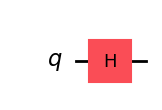

In [19]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
 
# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)
 
H = SparsePauliOp(["X", "Z"], [2, -1])
 
aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)
 
original_circuit.draw("mpl")

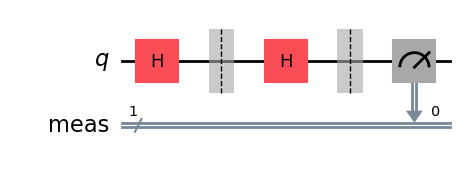

In [20]:
# Auxiliary circuit for X
aux_circuits[0].draw("mpl")

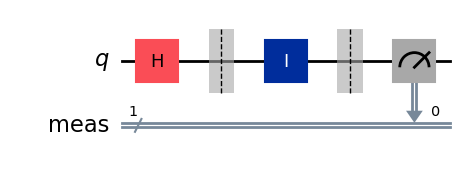

In [21]:
# Auxiliary circuit for Z
aux_circuits[1].draw("mpl")

In [22]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
import numpy as np
 
 
## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots=shots)
 
# Run the sampler job and step through results
expvals = []
for index, pauli in enumerate(H.paulis):
    data_pub = job.result()[index].data
    bitstrings = data_pub.meas.get_bitstrings()
    counts = data_pub.meas.get_counts()
    quasi_dist = QuasiDistribution(
        {outcome: freq / shots for outcome, freq in counts.items()}
    )
 
    # Use the probabilities and known eigenvalues of Pauli operators to estimate the expectation value.
    val = 0
 
    if str(pauli) == "X":
        val += -1 * quasi_dist.get(1, 0)
        val += 1 * quasi_dist.get(0, 0)
 
    if str(pauli) == "Y":
        val += -1 * quasi_dist.get(1, 0)
        val += 1 * quasi_dist.get(0, 0)
 
    if str(pauli) == "Z":
        val += 1 * quasi_dist.get(0, 0)
        val += -1 * quasi_dist.get(1, 0)
 
    expvals.append(val)
 
# Print expectation values
 
print("Sampler results:")
for pauli, expval in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")
 
total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")
 
# Use estimator for comparison
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H
 
estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs
 
# Print results
print("Estimator results:")
for obs, expval in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00060
  >> Total expected value: 1.99940
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


## Cost functions

In general, cost functions are used to describe the goal of a problem and how well a trial state is performing with respect to that goal.

Let's consider a simple example of finding the ground state of a system. Our objective is to minimize the expectation value of the observable representing energy (Hamiltonian $\hat{\mathcal{H}}$):

$$
\min_{\vec\theta} \langle\psi(\vec\theta)|\hat{\mathcal{H}}|\psi(\vec\theta)\rangle
$$

We can use the `Estimator` to evaluate the expectation value and pass this value to an optimizer to minimize. If the optimization is successful, it will return a set of optimal parameter values $\vec\theta^*$, from which we will be able to construct the proposed solution state $|\psi(\vec\theta^*)\rangle$ and compute the observed expectation value as $C(\vec\theta^*)$.

Notice how we will only be able to minimize the cost function for the limited set of states that we are considering. This leads us to two separate possibilities:

*   **Our ansatz does not define the solution state across the search space**: If this is the case, our optimizer will never find the solution, and we need to experiment with other ansatzes that might be able to represent our search space more accurately.
*   **Our optimizer is unable to find this valid solution**: Optimization can be globally defined and locally defined. We'll explore what this means in the later section.

>   Think of the optimization as a purely classical endeavor where we call some [black-box quantum oracle][oracle] each time the optimizer needs to evaluate the cost function.

[oracle]: #definition-tooltip "A hypothetical device or software component that performs a specific function, but the internal workings of which are unknown. A user is only aware of the inputs and outputs of the black box, and has no knowledge of how the black box processes the inputs to produce the outputs."



In [13]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

C:\Users\berli\AppData\Local\Temp\ipykernel_59688\1671795222.py:8: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  variational_form = TwoLocal(


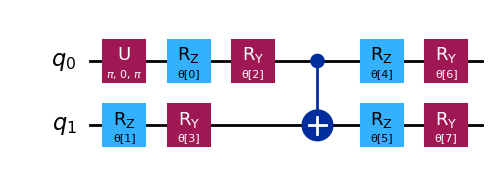

In [57]:
from qiskit.circuit.library import TwoLocal
 
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])
 
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
 
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)
 
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
ansatz.decompose().draw("mpl")

In [58]:
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-0.77936692]


We will first carry this out using a simulator: the `StatevectorEstimator`. This is usually advisable for debugging, but we will immediately follow the debugging run with a calculation on real quantum hardware. Increasingly, problems of interest are no longer classically simulable without state-of-the-art supercomputing facilities.

In [55]:
# Load necessary packages:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorOptions,
    EstimatorV2 as Estimator,
)
from qiskit import transpile

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, min_num_qubits=ansatz.num_qubits, simulator=False)

# 1) Transpile circuit to backend’s ISA
isa_ansatz = transpile(ansatz, backend=backend, optimization_level=2,
                       layout_method="sabre", routing_method="sabre")

# 2) Align observable with the transpiled layout
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

# 3) Estimator (no Session on Open plan)
estimator = Estimator(mode=backend,
                      options=EstimatorOptions(resilience_level=1, default_shots=10000))

# 4) Use matching parameter vector length
theta_list = np.random.rand(isa_ansatz.num_parameters).tolist()

#cost = estimator.run([(isa_ansatz, isa_observable, theta_list)]).result()[0]
#print("Energy:", cost)

cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)
print("Cost:", cost)


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-14 16:19:39,401: Default instance not set. Searching all available instances.


Cost: -0.5391744776230754


You should get a similar value as above.

## Max-Cut Problem

The **maximum cut (Max-Cut)** problem is a classic optimization problem on graphs.  
The task is to split the set of vertices $ V $ of a graph $ G=(V,E) $ into two groups so that as many edges as possible connect vertices from different groups.  

Formally, we want a partition of $ V $ into two disjoint sets $ S $ and $ T $,  
where the number of edges with one endpoint in $ S $ and the other in $ T $ is maximized.


Max-Cut shows up in many practical areas, such as:
- **Clustering**: separating data points into well-defined groups.  
- **Network design**: maximizing flow or resilience by splitting nodes.  
- **Physics**: studying spin systems and phase transitions.  

We’ll begin by creating a simple problem graph to demonstrate how this works.


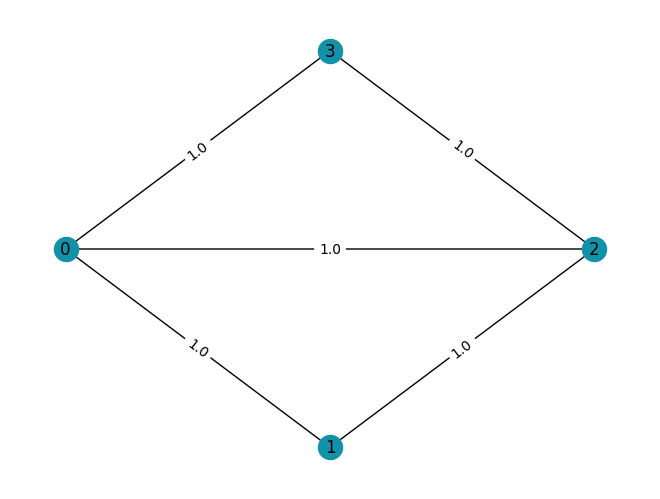

In [60]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
 
n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)
 
mpl_draw(
    G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192A9"
)

This problem can be expressed as a binary optimization problem. For each node $0 \leq i < n$, where $n$ is the number of nodes of the graph (in this case $n=4$), we will consider the binary variable $x_i$. This variable will have the value $1$ if node $i$ is one of the groups that we'll label $1$ and $0$ if it's in the other group, that we'll label as $0$. We will also denote as $w_{ij}$ (element $(i,j)$ of the adjacency matrix $w$) the weight of the edge that goes from node $i$ to node $j$. Because the graph is undirected, $w_{ij}=w_{ji}$. Then we can formulate our problem as maximizing the following cost function:

$$
\begin{aligned}
C(\vec{x})
& =\sum_{i,j=0}^n w_{ij} x_i(1-x_j)\\[1mm]

& = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i,j=0}^n w_{ij} x_ix_j\\[1mm]

& = \sum_{i,j=0}^n w_{ij} x_i - \sum_{i=0}^n \sum_{j=0}^i 2w_{ij} x_ix_j
\end{aligned}
$$

To solve this problem with a quantum computer, we are going to express the cost function as the expected value of an observable. However, the observables that Qiskit admits natively consist of Pauli operators, that have eigenvalues $1$ and $-1$ instead of $0$ and $1$. That's why we are going to make the following change of variable:

Where $\vec{x}=(x_0,x_1,\cdots ,x_{n-1})$. We can use the adjacency matrix $w$ to comfortably access the weights of all the edge. This will be used to obtain our cost function:

$$
z_i = 1-2x_i \rightarrow x_i = \frac{1-z_i}{2}
$$

This implies that:

$$
\begin{array}{lcl} x_i=0 & \rightarrow & z_i=1 \\ x_i=1 & \rightarrow & z_i=-1.\end{array}
$$

So the new cost function we want to maximize is:

$$
\begin{aligned}
C(\vec{z})
& = \sum_{i,j=0}^n w_{ij} \bigg(\frac{1-z_i}{2}\bigg)\bigg(1-\frac{1-z_j}{2}\bigg)\\[1mm]

& = \sum_{i,j=0}^n \frac{w_{ij}}{4} - \sum_{i,j=0}^n \frac{w_{ij}}{4} z_iz_j\\[1mm]

& = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j
\end{aligned}
$$

Moreover, the natural tendency of a quantum computer is to find minima (usually the lowest energy) instead of maxima so instead of maximizing $C(\vec{z})$ we are going to minimize:

$$
-C(\vec{z}) =  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} z_iz_j -  \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$

Now that we have a cost function to minimize whose variables can have the values $-1$ and $1$, we can make the following analogy with the Pauli $Z$:

$$
z_i \equiv Z_i = \overbrace{I}^{n-1}\otimes ... \otimes \overbrace{Z}^{i} \otimes ... \otimes \overbrace{I}^{0}
$$

In other words, the variable $z_i$ will be equivalent to a $Z$ gate acting on qubit $i$. Moreover:

$$
Z_i|x_{n-1}\cdots x_0\rangle = z_i|x_{n-1}\cdots x_0\rangle \rightarrow \langle x_{n-1}\cdots x_0 |Z_i|x_{n-1}\cdots x_0\rangle = z_i
$$

Then the observable we are going to consider is:

$$
\hat{H} = \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2} Z_iZ_j
$$

to which we will have to add the independent term afterwards:

$$
\texttt{offset} = - \sum_{i=0}^n \sum_{j=0}^i \frac{w_{ij}}{2}
$$



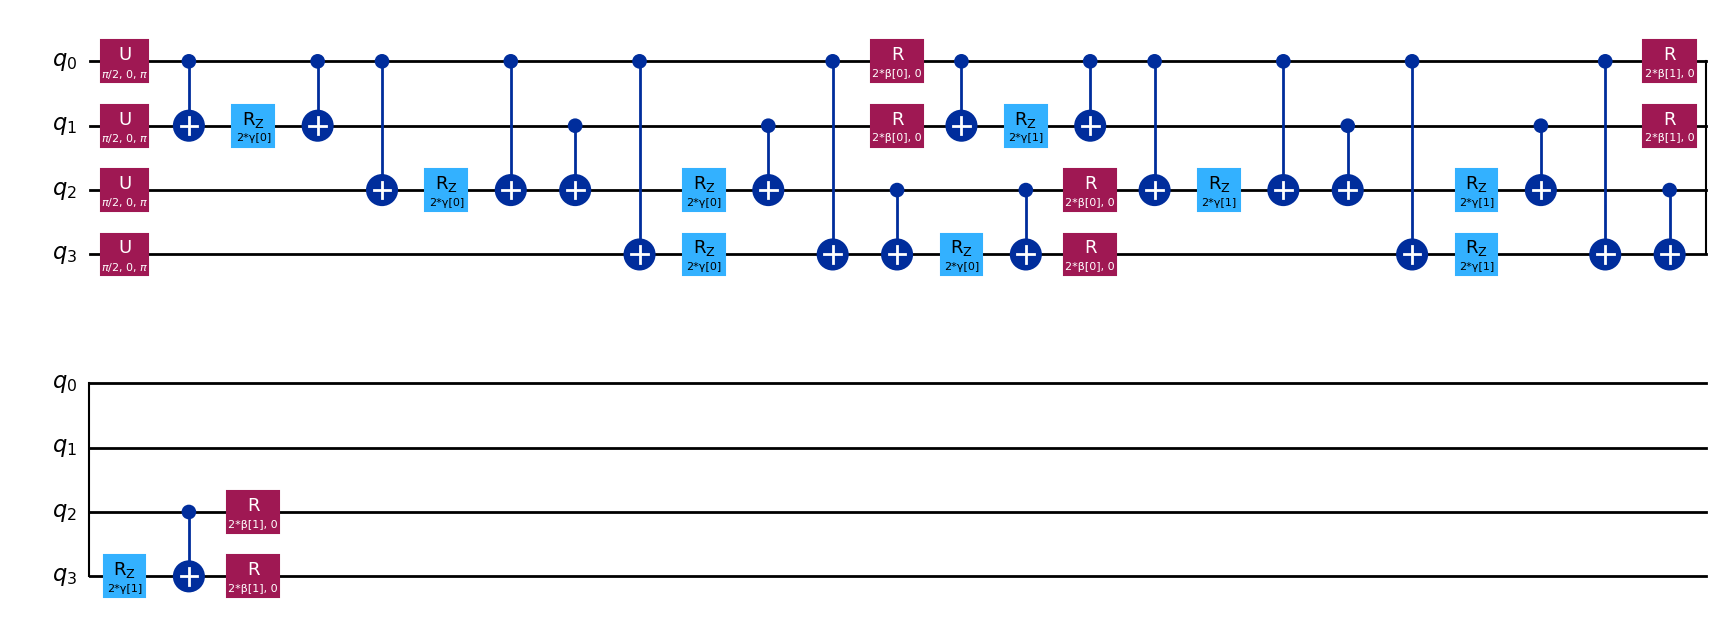

In [61]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
 
hamiltonian = SparsePauliOp.from_list(
    [("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)]
)
 
 
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [62]:
# Sum the weights, and divide by 2
 
offset = -sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    #    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [70]:
import numpy as np
 
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
 
estimator = StatevectorEstimator()
cost = cost_func_vqe(x0, ansatz, hamiltonian, estimator)
print(cost)

-0.4455105754052492


In [72]:
# Load necessary packages:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    EstimatorOptions,
    EstimatorV2 as Estimator,
)
from qiskit import transpile

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, min_num_qubits=ansatz.num_qubits, simulator=False)

# 1) Transpile circuit to backend’s ISA
isa_ansatz = transpile(ansatz, backend=backend, optimization_level=2,
                       layout_method="sabre", routing_method="sabre")

# 2) Align observable with the transpiled layout
isa_observable = hamiltonian.apply_layout(layout=isa_ansatz.layout)

# 3) Estimator (no Session on Open plan)
estimator = Estimator(mode=backend,
                      options=EstimatorOptions(resilience_level=1, default_shots=10000))

# 4) Use matching parameter vector length
theta_list = np.random.rand(isa_ansatz.num_parameters).tolist()

cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)
print("Cost:", cost)


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-14 20:06:59,738: Default instance not set. Searching all available instances.


Cost: -0.3072459881850411


Error suppression refers to techniques used to optimize and transform a circuit during compilation in order to minimize errors. This is a basic error handling technique that usually results in some classical pre-processing overhead to the overall runtime. The overhead includes transpiling circuits to run on quantum hardware by:

*   Expressing the circuit using the native gates available on a quantum system
*   Mapping the virtual qubits to physical qubits
*   Adding SWAPs based on connectivity requirements
*   Optimizing 1Q and 2Q gates
*   Adding dynamical decoupling to idle qubits to prevent the effects of decoherence.

Primitives allow for the use of error suppression techniques by setting the `optimization_level` option and selecting advanced transpilation options. In a later course, we will delve into different circuit construction methods to improve results, but for most cases, we recommend setting `optimization_level=3`.

We will visualize the value of increasing optimization in the transpilation process by looking at an example circuit with a simple ideal behavior.

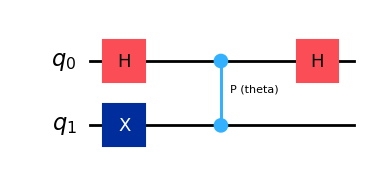

In [2]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
 
theta = Parameter("theta")
 
qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])
 
qc.draw("mpl")

The circuit above can yield sinusoidal expectation values of the observable given, provided we insert phases spanning an appropriate interval, such as $[0, 2\pi]$

In [3]:
## Setup phases
import numpy as np
 
phases = np.linspace(0, 2 * np.pi, 50)
 
# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

We can use a simulator to show the usefulness of an optimized transpilation. We will return below to using real hardware to demonstrate the usefulness of error mitigation. We will use QiskitRuntimeService to get a real backend (in this case, ibm_brisbane), and use AerSimulator to simulate that backend, including its noise behavior.

In [7]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
 
# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, min_num_qubits=qc.num_qubits)
 
# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-14 20:31:59,368: Default instance not set. Searching all available instances.


We can now use a pass manager to transpile the circuit into the "instruction set architecture" or ISA of the backend. This is a new requirement in Qiskit Runtime: all circuits submitted to a backend must conform to the constraints of the backend’s target, meaning they must be written in terms of the backend's ISA — that is, the set of instructions the device can understand and execute. These target constraints are defined by factors like the device’s native basis gates, its qubit connectivity, and - when relevant - its pulse and other instruction timing specifications.

Note that in the present case, we will do this twice: once with optimization_level = 0, and once with it set to 3. Each time we will use the Estimator primitive to estimate the expectation values of the observable at different values of phase.

In [22]:
# Import estimator and specify that we are using the simulated backend:
 
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(mode=backend_sim)
 
circuit = qc

In [27]:
# Use a pass manager to transpile the circuit and observable for the backend being simulated.
# Start with no optimization:
from qiskit import transpile

backend = AerSimulator()

isa_circuit = transpile(qc, backend=backend, optimization_level=0,
                       layout_method="sabre", routing_method="sabre")

isa_observables = observables.apply_layout(layout=isa_circuit.layout)
 
noisy_exp_values = []
pub = (isa_circuit, isa_observables, [individual_phases])

estimator = Estimator(mode=backend)
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

# Repeat above steps, but now with optimization = 3:
 
exp_values_with_opt_es = []
isa_circuit = transpile(qc, backend=backend, optimization_level=3,
                       layout_method="sabre", routing_method="sabre")
isa_observables = observables.apply_layout(layout=isa_circuit.layout)
 
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]

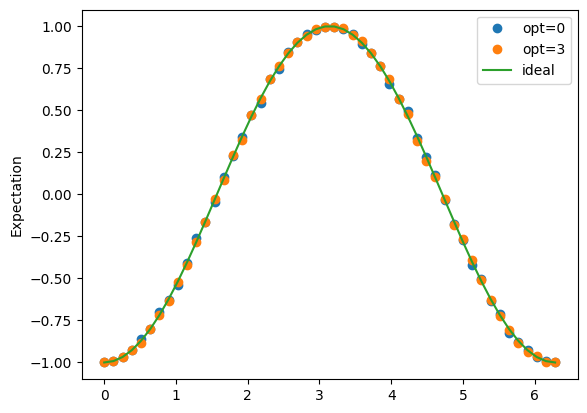

In [28]:
import matplotlib.pyplot as plt
 
plt.plot(phases, noisy_exp_values, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

## Error Mitigation

Error mitigation refers to techniques that allow users to reduce circuit errors by modeling the device noise at the time of execution. Typically, this results in quantum pre-processing overhead related to model training and classical post-processing overhead to mitigate errors in the raw results by using the generated model.

The Qiskit Runtime primitive's resilience_level option specifies the amount of resilience to build against errors. Higher levels generate more accurate results at the expense of longer processing times due to quantum sampling overhead. Resilience levels can be used to configure the trade-off between cost and accuracy when applying error mitigation to your primitive query.

When implementing any error mitigation technique, we expect the bias in our results to be reduced with respect to the previous, unmitigated bias. In some cases, the bias may even disappear. However, this comes at a cost. As we reduce the bias in our estimated quantities, the statistical variability will increase (that is, variance), which we can account for by further increasing the number of shots per circuit in our sampling process. This will introduce overhead beyond that needed to reduce the bias, so it is not done by default. We can easily opt-in to this behavior by adjusting the number of shots per circuit in options.executions.shots, as shown in the example below.



## Twirled readout error extinction (T-REx)

Twirled readout error extinction (T-REx) uses a technique known as Pauli twirling to reduce the noise introduced during the process of quantum measurement. This technique assumes no specific form of noise, which makes it very general and effective.

Overall workflow:

1.  Acquire data for the zero state with randomized bit flips (Pauli X before measurement)
2.  Acquire data for the desired (noisy) state with randomized bit flips (Pauli X before measurement)
3.  Compute the special function for each data set, and divide.

Zero noise extrapolation
Zero noise extrapolation (ZNE) works by first amplifying the noise in the circuit that is preparing the desired quantum state, obtaining measurements for several different levels of noise, and using those measurements to infer the noiseless result.

Overall workflow:

1.  Amplify circuit noise for several noise factors
2.  Run every noise amplified circuit
3.  Extrapolate back to the zero noise limit

We can set this with `options.resilience_level = 2`. We can optimize this further by exploring a variety of `noise_factors`, `noise_amplifiers`, and extrapolators, but this is outside the scope of this course. We encourage you to experiment with these options as described here.

$$
\begin{array}{c|c|c|c}
  \text{Methods} & R=1 \text{, T-REx} & R=2 \text{, ZNE} \\[1mm]
  \hline
  \text{Assumptions} & \text{None} & \text{Ability to scale noise} \\[1mm]
  \text{Qubit overhead} & 1 & 1 \\[1mm]
  \text{Sampling overhead} & 2 & N_{\text{noise-factors}} \\[1mm]
  \text{Bias} & 0 & \mathcal{O}(\lambda^{N_{\text{noise-factors}}}) \\[1mm]
\end{array}
$$

Each method comes with its own associated overhead: a trade-off between the number of quantum computations needed (time) and the accuracy of our results:

### Using Qiskit Runtime's mitigation and suppression options

Here's how to calculate an expectation value while using error mitigation and suppression in Qiskit Runtime. We can make use of precisely the same circuit and observable as before, but this time keeping the optimization level fixed at level 2, and now tuning the resilience or the error mitigation technique(s) being used. This error mitigation process occurs multiple times throughout an optimization loop.

We perform this part on real hardware, since error mitigation is not available on simulators.

In [ ]:
from qiskit_ibm_runtime import (
    EstimatorOptions,
    EstimatorV2 as Estimator,
)

# Initialize some variables to save the results from different runs:
exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []
 
# Resilience = 1
isa_circuit = transpile(qc, backend=backend)
isa_observables = observables.apply_layout(layout=isa_circuit.layout)

estimator_options = EstimatorOptions(resilience_level=0, default_shots=10000)

pub = (isa_circuit, isa_observables, [individual_phases])

estimator = Estimator(mode=backend)
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs

exp_values_with_em0_es = cost[0]

# Resilience = 1
isa_circuit = transpile(qc, backend=backend)
isa_observables = observables.apply_layout(layout=isa_circuit.layout)

estimator_options = EstimatorOptions(resilience_level=1, default_shots=10000)

pub = (isa_circuit, isa_observables, [individual_phases])

estimator = Estimator(mode=backend)
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs

exp_values_with_em1_es = cost[0]

# Resilience = 2:
isa_circuit = transpile(qc, backend=backend)
isa_observables = observables.apply_layout(layout=isa_circuit.layout)

estimator_options = EstimatorOptions(resilience_level=2, default_shots=10000)

pub = (isa_circuit, isa_observables, [individual_phases])

estimator = Estimator(mode=backend)
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs

exp_values_with_em2_es = cost[0]


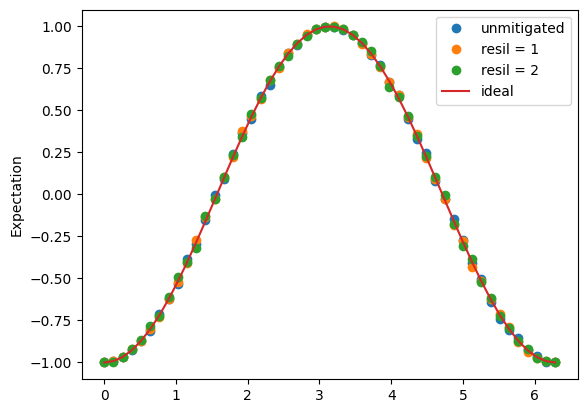

In [30]:
import matplotlib.pyplot as plt
 
plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()